# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm

Load feature names.

In [3]:
feature_names = []
with open('/Users/cjllop/Code/MIDS/MLearning/Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)


Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [4]:
X, Y = [], []

with open('/Users/cjllop/Code/MIDS/MLearning/Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

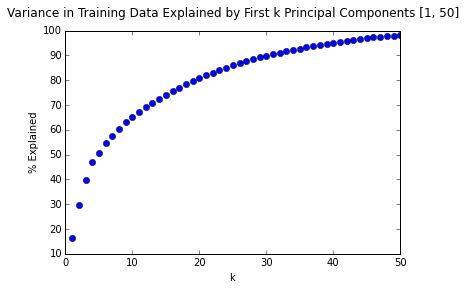

In [5]:
def P1():
### STUDENT START ###
    explained = []
    # Iterate thru [1,50]
    for k in range (1,51):
        # Fit PCA
        pca = PCA(n_components=k)
        pca.fit(train_data)
        # Caculate the total explained variance by the sum of that additionally explained by each k
        explained.append(sum(pca.explained_variance_ratio_) * 100)
        
    plt.plot(range(1,51),explained,'bo')
    plt.title('Variance in Training Data Explained by First k Principal Components [1, 50]', y=1.04)
    plt.xlabel('k')
    plt.ylabel('% Explained')
### STUDENT END ###

P1()

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

Sanity check, confirm 7000 = 7000


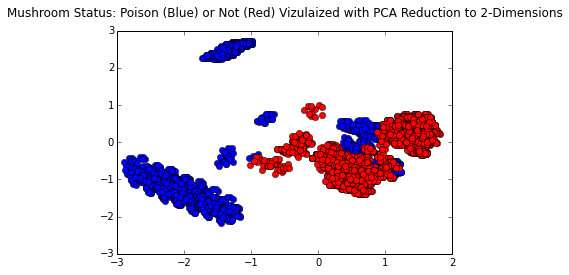

In [215]:
#def P2():
### STUDENT START ###
# Fit n=2 PCA
pca = PCA(n_components=2)
pca.fit(train_data)
# Apply dimension reduction
pca_train = pca.transform(train_data)

# Subset into two groups for plotting
poison = pca_train[train_labels==1]
not_poison = pca_train[train_labels==0]
print "Sanity check, confirm {} = {}".format(poison.shape[0] + not_poison.shape[0], train_data.shape[0])

# Plot in two colors, blue is poisonous and red is not as requested. Though normally I think "red" means danger3c2
plt.plot(poison[:,0], poison[:,1], 'bo', not_poison[:,0], not_poison[:,1], 'ro')
plt.title('Mushroom Status: Poison (Blue) or Not (Red) Vizulaized with PCA Reduction to 2-Dimensions', y=1.04)

### STUDENT END ###

#P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

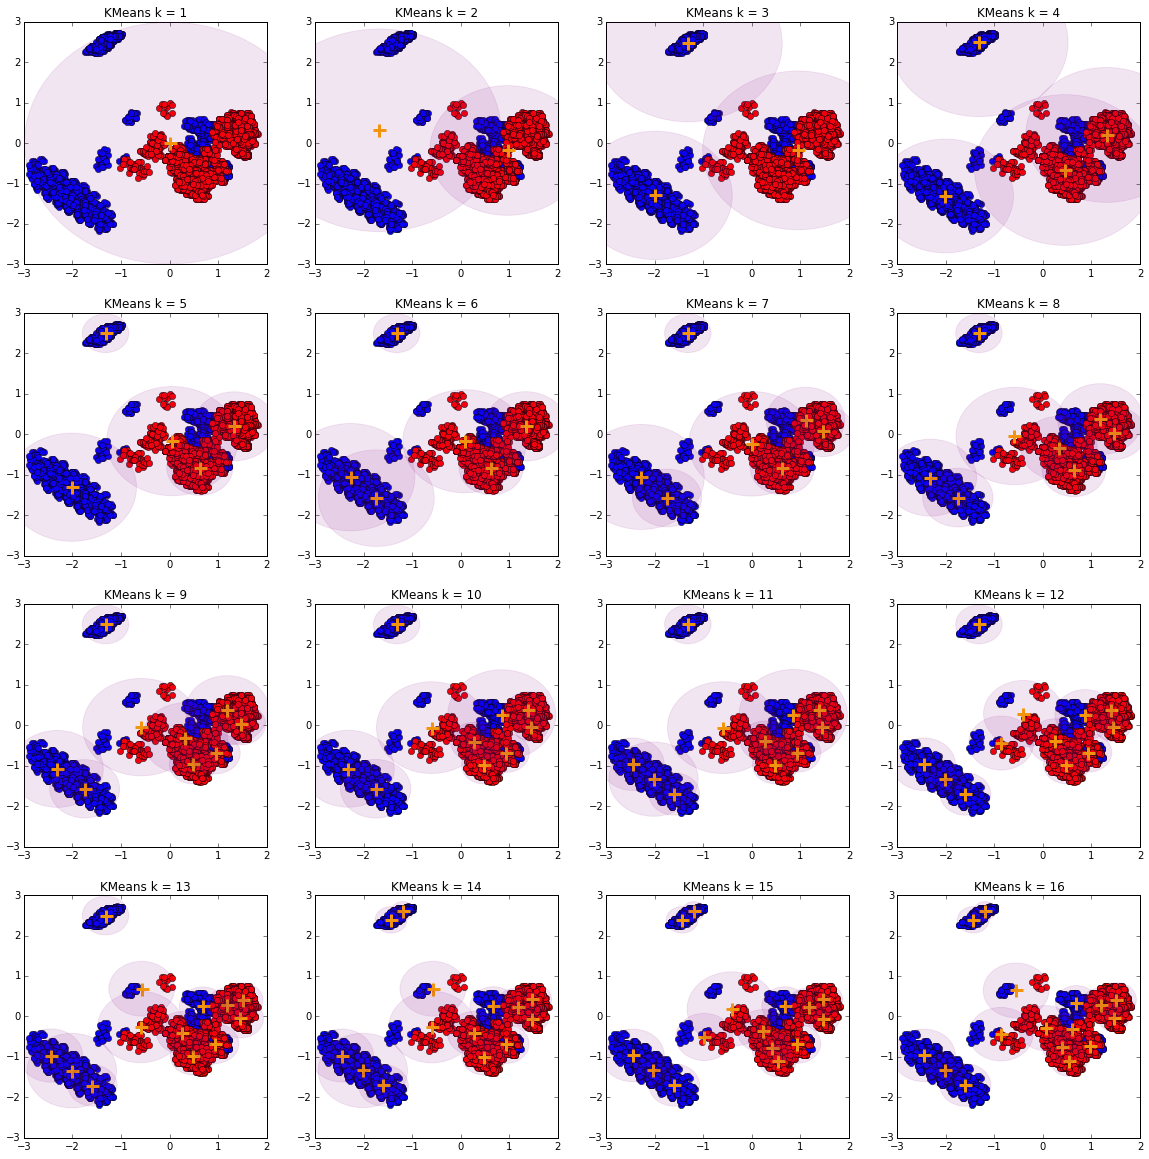

In [7]:
#def P3():
### STUDENT START ###
plt.figure(figsize=(20,20))
for k in range (1,17):
    # Fit KMeans Model (note, variables created in previous problem are stored in global memory)
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit(pca_train)

    p = plt.subplot(4, 4, k)
    # Plot Points
    p.plot(poison[:,0], poison[:,1], 'bo', not_poison[:,0], not_poison[:,1], 'ro', zorder=1)
    # Plot Centroids
    p.plot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color='orange', marker='+', markersize=13, 
           markeredgewidth=3, linewidth=0, zorder=3)

    # Calculate the furtherst point from each centroid, then plot it
    for x in range(0, kmeans.cluster_centers_.shape[0]):
        # Distance: linalg.norm defaults to a Frobenius norm with L2 (Euclidian distance)
        dist = np.linalg.norm(pca_train[kmeans.labels_ == x] - kmeans.cluster_centers_[x], axis=1)
        r = dist.max()
        # Add circle to plot
        p.add_artist(plt.Circle(xy=(kmeans.cluster_centers_[x,0], kmeans.cluster_centers_[x,1]), 
                                radius=r, color='purple', alpha=0.1, zorder = 3))      

    # Add a title
    plt.title('KMeans k = {}'.format(k))
### STUDENT END ###

#P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

0 spherical
1 diag
2 tied
3 full


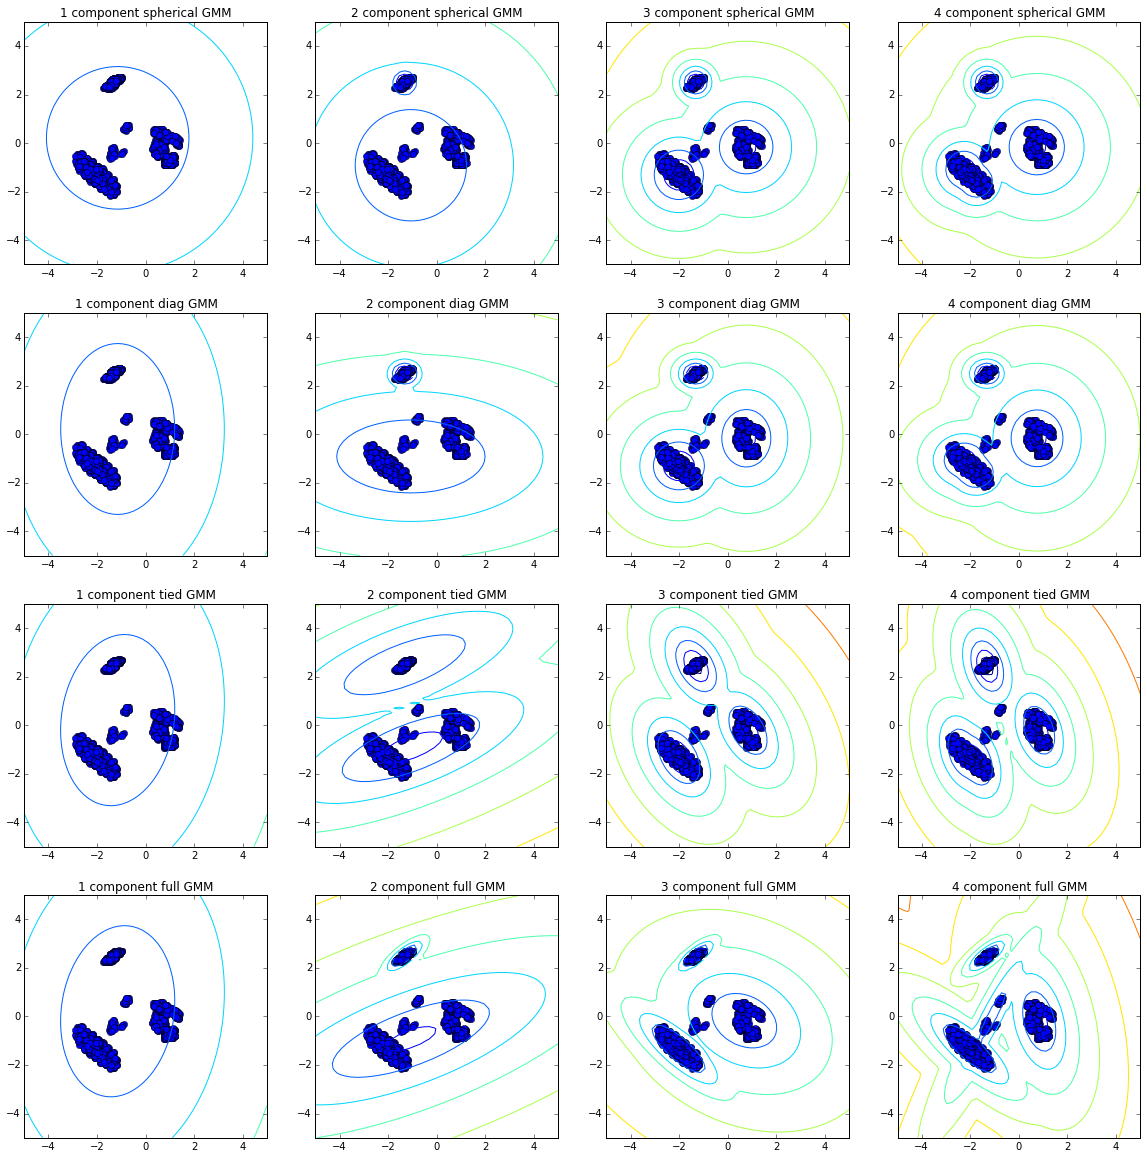

In [95]:
#def P4():
### STUDENT START ###
plt.figure(figsize=(20,20))

covar_types = ['spherical', 'diag', 'tied', 'full']
for i, covar_type in enumerate(covar_types):
    
    for comp in range(1,5):   
        plt.subplot(4, 4, (4*i) + comp)

        # fit a Gaussian Mixture Model
        clf = GMM(n_components=comp, covariance_type=covar_type)
        clf.fit(poison)

        # Display predicted scores as a contour plot
        x = np.linspace(-5.0, 5.0)
        y = np.linspace(-5.0, 5.0)
        X, Y = np.meshgrid(x, y)
        XX = np.array([X.ravel(), Y.ravel()]).T
        Z = -clf.score_samples(XX)[0]
        Z = Z.reshape(X.shape)

        # Note: Spent significant time playing with these parameters. Ended up deciding the ones from
        # the example code suggested plots nicely.
        CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10))
        #CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0))
        # plt.clabel(CS, inline=10, fontsize=10)
        #CB = plt.colorbar(CS, shrink=0.8, extend='both')
        plt.plot(poison[:,0], poison[:,1], 'bo', zorder=-1)
        plt.title(str(comp) + " component " +  covar_type + " GMM")

### STUDENT END ###

#P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

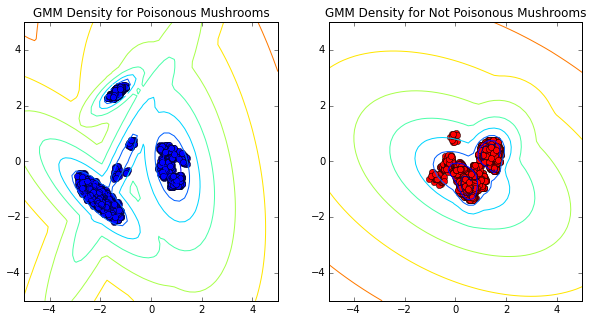

Our GMM correctly predicts if a mushroom is poisonous 95.11% of the time.


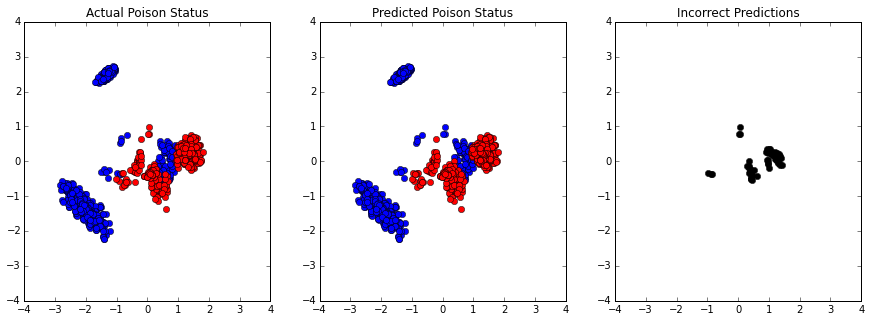

Note: We see that incorrect predictions occur in areas where our density plots most overlap


In [149]:
#def P5():
### STUDENT START ###

# Use PCA to transform the test data. Note that we've already fit to the train data in P2, so we should
# just transform the test data using the fit we found for the training data
pca_test = pca.transform(test_data)

# Fit GMM for positive examples
pos_GMM = GMM(n_components=4, covariance_type='full')
pos_GMM.fit(poison)

# Fit GMM for negative examples
neg_GMM = GMM(n_components=4, covariance_type='full')
neg_GMM.fit(not_poison)

# Let's viz both GMM just to sanity check
def viz_GMM(example_GMM):
    #See comments in P4
    x = np.linspace(-5.0, 5.0)
    y = np.linspace(-5.0, 5.0)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -example_GMM.score_samples(XX)[0]
    Z = Z.reshape(X.shape)

    CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10))

#Positive Viz
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
viz_GMM(pos_GMM)
plt.plot(poison[:,0], poison[:,1], 'bo', zorder=-1)
plt.title("GMM Density for Poisonous Mushrooms")

#Negative Viz
plt.subplot(1, 2, 2)
plt.plot(not_poison[:,0], not_poison[:,1], 'ro', zorder=-1)
viz_GMM(neg_GMM)
plt.title("GMM Density for Not Poisonous Mushrooms")
plt.show()

# Score both positive and negative for each model
test_pos_predict = pos_GMM.score(pca_test)
test_neg_predict = neg_GMM.score(pca_test)

# Predict based on the larger of the two (if tie, default to poisonous to give conservative advise re. eating the mushroom)
predict_labels = (test_pos_predict >= test_neg_predict).astype(int)

# Calculate Accuracy
print 'Our GMM correctly predicts if a mushroom is poisonous {:.2%} of the time.'.format(np.mean(predict_labels == test_labels))

# Visualize the training data and labels/predictions
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.plot(pca_test[test_labels==1,0], pca_test[test_labels==1,1], 'bo', pca_test[test_labels==0,0], pca_test[test_labels==0,1], 'ro')
plt.xlim(-4,4); plt.ylim(-4,4)
plt.title("Actual Poison Status")
plt.subplot(1, 3, 2)
plt.plot(pca_test[predict_labels==1,0], pca_test[predict_labels==1,1], 'bo', pca_test[predict_labels==0,0], pca_test[predict_labels==0,1], 'ro')
plt.xlim(-4,4); plt.ylim(-4,4)
plt.title("Predicted Poison Status")
plt.subplot(1, 3, 3)
plt.plot(pca_test[predict_labels!=test_labels,0], pca_test[predict_labels!=test_labels,1], 'ko')
plt.xlim(-4,4); plt.ylim(-4,4)
plt.title("Incorrect Predictions")
plt.show()

print "Note: We see that incorrect predictions occur in areas where our density plots most overlap"

### STUDENT END ###

#P5()

(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [213]:
#def P6():
### STUDENT START ###
# Let's start by articulating the formulas to calculate the number of parameters.
# I derived these formulas using a combination of the notes from Office Hours, and the images located
# on this example: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_classifier.html
# Sphere: ((p mean_vector + 1 cov_matrix) * D components) * 2 classes
# Diag: ((p mean_vector + p cov_matrix) * D components) * 2 classes
# Tied: ((p mean_vector * D components) + (p + p * (p-1) / 2) cov_matrix) * 2 classes
# Full: ((p mean_vector * (p + p * (p-1) / 2) cov_matrix) * D components) * 2 classes


# To enable looping later, let's create a function that returns the number of parameters based on our formulas above
def calc_para(covar, p, D):
    if covar == 'spherical':
        return ((p + 1) * D) * 2
    elif covar == 'diag':
        return ((p + p) * D) * 2
    elif covar == 'tied':
        return ((p * D) + (p + p * (p-1) / 2)) * 2
    elif covar == 'full':
        return ((p * (p + p * (p-1) / 2)) * D) * 2

# Arrays to store results for printing later
p_array = []
D_array = []
covar_type_array = []
x_array = []
accuracy_array = []

# For the outer loop, we try different dimensions via PCA reductions
# We can iterate the number of dimensions from 1-24 (instead of 50) by setting our parameters equation for
# the spherical case equal to 50 then solving for p. This gives us ((p + 1) * D) * 2 = 50. From this equation,
# p is maximized when D =1, giving ((p + 1) * 2) = 50 -> max p = 24
for p in range (1,25):

    print "Calculating p={}".format(p)
    # PCA Reduce
    pca = PCA(n_components=p)
    pca.fit(train_data)
    pca_train = pca.transform(train_data)
    pca_test = pca.transform(test_data)

    # Subset into two groups for plotting
    poison = pca_train[train_labels==1]
    not_poison = pca_train[train_labels==0]

    # For the middle loop, we try each covar_type
    covar_types = ['spherical','diag','tied','full']
    for i, covar_type in enumerate(covar_types):
        # Calculate number of components
        D = 1
        x = calc_para(covar_type, p, D)

        # For the inner loop, we try different components, remaining flexible to exit via a while loop
        while x <= 50:
            # Fit
            pos_GMM = GMM(n_components=D, covariance_type=covar_type)
            pos_GMM.fit(poison)
            neg_GMM = GMM(n_components=D, covariance_type=covar_type)
            neg_GMM.fit(not_poison)
            # Predict
            test_pos_predict = pos_GMM.score(pca_test)
            test_neg_predict = neg_GMM.score(pca_test)
            predict_labels = (test_pos_predict >= test_neg_predict).astype(int)
            #print '{} dimension {} component {} GMM has {} parameters and accuracy of: {:.2%}.'.format(p, D, covar_type, x, np.mean(predict_labels == test_labels))

            # Append results and parameters to arrays for later lookup
            p_array.append(p)
            D_array.append(D)
            covar_type_array.append(covar_type)
            x_array.append(x)
            accuracy_array.append(np.mean(predict_labels == test_labels))
            
            # Update number of components
            D += 1
            x = calc_para(covar_type, p, D)

# Now print the best answer
i = accuracy_array.index(max(accuracy_array))
print
print 'The best fit with x <= 50 is {} dimension {} component {} GMM with {} parameters and accuracy of {:.2%}.'.format(p_array[i], D_array[i], covar_type_array[i], x_array[i], accuracy_array[i])

### STUDENT END ###

#P6()

Calculating p=1
Calculating p=2
Calculating p=3
Calculating p=4
Calculating p=5
Calculating p=6
Calculating p=7
Calculating p=8
Calculating p=9
Calculating p=10
Calculating p=11
Calculating p=12
Calculating p=13
Calculating p=14
Calculating p=15
Calculating p=16
Calculating p=17
Calculating p=18
Calculating p=19
Calculating p=20
Calculating p=21
Calculating p=22
Calculating p=23
Calculating p=24

The best fit with x <= 50 is 7 dimension 3 component spherical GMM with 48 parameters and accuracy of 97.33%.
